In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.metrics import matthews_corrcoef
from scipy.stats import pearsonr
import kagglehub
from kagglehub import KaggleDatasetAdapter

# V cramer

El estadístico **V Cramer** se define así:

$$ V = \sqrt{\frac{\frac{\chi^{2}}{n}}{\min(k-1, r-1)}}$$

De donde se tiene que:

$$ \chi^{2} = \sum_{i,j}\frac{\left(O_{ij} - E_{ij}\right)^{2}}{E_{ij}} \text{, donde } i \in (1, 2, \dots, r) \text{ y } j \in (1, 2, \dots k)$$


Vale la pena aclarar que:
- $O_{ij}$ es la frecuencia observada de ocurrencia simultanea de la variable A con nivel i y la variable B con nivel j.
- $E_{ij}$ es el valor esperado de la ocurrencia simultanea de la variable A con nivel i y la variable B con nivel j. Pero asumiendo independencia entre las variables A y B.

Si definimos $f(\cdot)$ como la frecuencia de ocurrencia de $(\cdot)$. Se puede definir desde el punto de vista frecuentista de probabilidad que:

- $P(A_i) \approx \frac{f(A_i)}{n}$
- $P(B_j) \approx \frac{f(B_j)}{n}$
- $P(A_i \cap B_j) \approx \frac{f(A_i \cap B_j)}{n}$

Cuando se dice que las variables son independientes se está diciendo que:

- $P(A_i \cap B_i) = P(A_i)P(B_j)$

Entonces se puede hacer la siguiente aproximación:

- $\frac{f(A_i \cap B_j)}{n} \approx \frac{f(A_i)}{n}\frac{f(A_j)}{n}$

Con ello:

$ f(A_i \cap B_j) \approx \frac{1}{n}f(A_i)f(A_j) = E_{ij} $


# Ejemplo
Datos de estudiantes de PYEF

In [2]:
# paths
datos_g10_path = "https://raw.githubusercontent.com/apolineo11/PYEF/main/Cuadernos/Data/Datos_Probabilidad_Grupo_10.xlsx"
datos_g11_path = "https://raw.githubusercontent.com/apolineo11/PYEF/main/Cuadernos/Data/Datos_Probabilidad_Grupo_11.xlsx"

# leer los datos estudiantes
datos_g10 = pd.read_excel(datos_g10_path)
datos_g11 = pd.read_excel(datos_g11_path, skiprows=1)

In [3]:
# limpieza datos estudiantes
datos_g10.rename(columns={"ESTRATO DEL PREDIO DONDE VIVE":"ESTRATO",
                          "EDAD (AÑOS)":"EDAD",
                          "PROGRAMA ACADÉMICO":"PROGRAMA",
                          "NÚMERO DE MATRICULAS": "MATRICULAS",
                          "ESTATURA (CM)": "ESTATURA",
                          "PESO (KG)": "PESO"}, inplace=True)
datos_g11.rename(columns={"ESTRATO DEL PREDIO DONDE VIVE ":"ESTRATO",
                          "EDAD (AÑOS)":"EDAD",
                          "PROGRAMA ACADEMICO":"PROGRAMA",
                          "NUMERO DE MATRICULAS": "MATRICULAS",
                          "ESTATURA (CM)": "ESTATURA",
                          "PESO KG)": "PESO"}, inplace=True)
columns_df = ["ESTRATO", "EDAD", "PROGRAMA", "MATRICULAS", "ESTATURA", "PESO"]
datos_g10 = datos_g10[columns_df]
datos_g11 = datos_g11[columns_df]
df = pd.concat([datos_g10, datos_g11])
programa_dict = {"ADMINISTRACIÓN": "ADMINISTRACION", "ECONOMÍA":"ECONOMIA", "CONTADURÍA PÚBLICA":"CONTADURIA PUBLICA"}
df.replace({"PROGRAMA": programa_dict}, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.astype({"EDAD": "int32", "MATRICULAS":"int32", "ESTRATO":"int32", "PROGRAMA":"category"})
df["ESTRATO"] = df["ESTRATO"].astype("str").astype("category")
df["ESTRATO"] = df["ESTRATO"].cat.reorder_categories(["1", "2", "3", "4", "5", "6"], ordered=True)


In [4]:
# visualización de las primeras filas
df.head(n=15)

,ESTRATO,EDAD,PROGRAMA,MATRICULAS,ESTATURA,PESO
0,1,24,ADMINISTRACION,6,175.0,67.0
1,3,25,ADMINISTRACION,4,145.0,60.0
2,5,18,ECONOMIA,3,185.0,87.0
3,3,20,ECONOMIA,3,173.0,57.0
4,5,17,ADMINISTRACION,3,160.0,58.0
5,3,17,ECONOMIA,3,180.0,60.0
6,3,18,ECONOMIA,4,182.0,80.0
7,3,28,ADMINISTRACION,8,160.0,85.0
8,3,19,ECONOMIA,4,170.0,68.0
9,4,20,ECONOMIA,3,150.0,40.0


In [5]:
# informacionm general del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ESTRATO     79 non-null     category
 1   EDAD        79 non-null     int32   
 2   PROGRAMA    79 non-null     category
 3   MATRICULAS  79 non-null     int32   
 4   ESTATURA    79 non-null     float64 
 5   PESO        79 non-null     float64 
dtypes: category(2), float64(2), int32(2)
memory usage: 2.5 KB


In [6]:
# descripcion del dataframe categoricas
df.describe(include=['object', 'category'])

,ESTRATO,PROGRAMA
count,79,79
unique,6,3
top,3,ECONOMIA
freq,39,34


In [7]:
# descripcion del dataframe numericas
df.describe()

,EDAD,MATRICULAS,ESTATURA,PESO
count,79.000000,79.000000,79.000000,79.000000
mean,21.012658,4.810127,169.607595,65.443038
std,4.146341,1.901929,10.082249,12.701450
min,17.000000,2.000000,145.000000,40.000000
25%,19.000000,3.000000,162.500000,57.000000
50%,20.000000,4.000000,170.000000,64.000000
75%,22.500000,6.000000,178.000000,71.000000
max,48.000000,9.000000,192.000000,120.000000


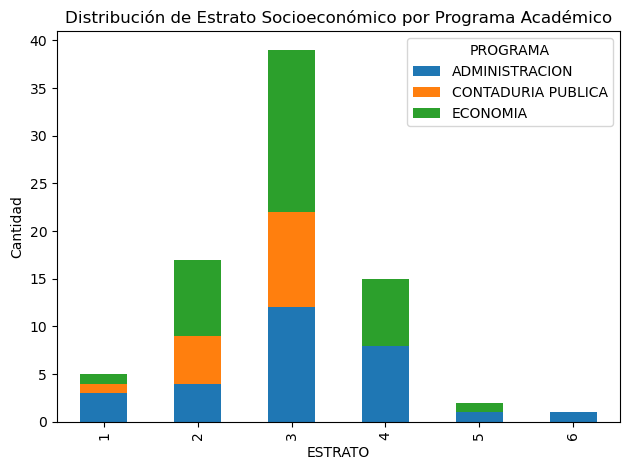

In [8]:
# Tabla de contingencia
tabla_cont = pd.crosstab(df['ESTRATO'], df['PROGRAMA'])

# Graficar barras apiladas
tabla_cont.plot(kind='bar', stacked=True)
plt.xlabel('ESTRATO')
plt.ylabel('Cantidad')
plt.title('Distribución de Estrato Socioeconómico por Programa Académico')
plt.legend(title='PROGRAMA')
plt.tight_layout()
plt.show()

In [9]:
# Mostrar la tabla de contigencia
pd.crosstab(df['ESTRATO'], df['PROGRAMA'], margins=True, margins_name="TOTAL")

PROGRAMA,ADMINISTRACION,CONTADURIA PUBLICA,ECONOMIA,TOTAL
ESTRATO,,,,
1,3,1,1,5
2,4,5,8,17
3,12,10,17,39
4,8,0,7,15
5,1,0,1,2
6,1,0,0,1
TOTAL,29,16,34,79


In [10]:
############
# V cramer #
############

# Estadístico chi-cuadrado
chi2_value, p, dof, expected = chi2_contingency(tabla_cont)

print("---")
print(f"El estadístico Chi-square para la tabla de contingencia es: {chi2_value:.3f}")
print("---")
print(f"Los grados de libertad (r-1)(k-1) de la tabla de contingencia es: {dof}")
print("---")
print(f"La matriz de valores esperados E_ij es:")
print(np.round(expected,2))
print(f"P-Valor para el estadístico: {p:.3f}")


---
El estadístico Chi-square para la tabla de contingencia es: 10.326
---
Los grados de libertad (r-1)(k-1) de la tabla de contingencia es: 10
---
La matriz de valores esperados E_ij es:
[[ 1.84  1.01  2.15]
 [ 6.24  3.44  7.32]
 [14.32  7.9  16.78]
 [ 5.51  3.04  6.46]
 [ 0.73  0.41  0.86]
 [ 0.37  0.2   0.43]]
P-Valor para el estadístico: 0.412


In [11]:
# Cálculo de V de Cramér
n = tabla_cont.sum().sum()
min_dim = min(tabla_cont.shape) - 1
v_cramer = np.sqrt(chi2_value / (n * min_dim))
print(f"V de Cramér: {v_cramer:.3f}")

V de Cramér: 0.256


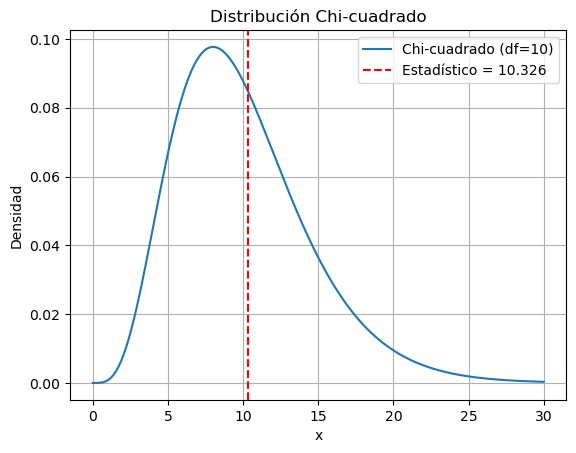

In [12]:
# Mostrar la distribución Chi square
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Rango de valores en el eje x
x = np.linspace(0, 30, 500)

# Calcular la densidad
pdf = chi2.pdf(x, dof)

# Graficar
plt.plot(x, pdf, label=f'Chi-cuadrado (df={dof})')
plt.axvline(x=chi2_value, color='red', linestyle='--', label=f'Estadístico = {chi2_value:.3f}')
plt.title('Distribución Chi-cuadrado')
plt.xlabel('x')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True)
plt.show()


# Coeficiente $\phi$

El coeficiente $\phi$ se define para una tabla de contigencia de **2** variables binarias:

La tabla de contigencia de las variables binarias A y B:

|               | B = 1 | B = 0 | Total       |
|---------------|-------|-------|-------------|
| A = 1         |   a   |   b   | a + b       |
| A = 0         |   c   |   d   | c + d       |
| **Total**     | a + c | b + d | n = a+b+c+d |


---

El coeficiente $\phi$ se define asi:

$$\phi = \frac{|ad - bc|}{\sqrt{(a+b)(c+d)(a+c)(b+d)}}$$

---

Para probar la significancia se usa el estadístico $\chi^{2}$ pero usando la corrección de **YATES** o de tambien llamada corrección de **continuidad**.

$$
\begin{align*}
    \chi_{Yates}^{2} =& \sum_{i,j}\frac{\left(|O_{ij} - E_{ij}| - \frac{n}{2}\right)^{2}}{E_{ij}} \\
    \chi_{Yates}^{2} =& \frac{n(|ad - bc| - \frac{n}{2})^{2}}{(a+b)(c+d)(a+c)(b+d)}
\end{align*}
$$

## Ejemplo

Datos de factores socioeconómicos

**Descarga aquí**: [https://www.kaggle.com/datasets/aldol07/socioeconomic-factors-and-income-dataset](https://www.kaggle.com/datasets/aldol07/socioeconomic-factors-and-income-dataset)

In [13]:
# datos kaggle
df_ka = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "aldol07/socioeconomic-factors-and-income-dataset",
    "sgdata.csv"
)

/tmp/ipykernel_41088/3384342009.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_ka = kagglehub.load_dataset(


In [14]:
# paso a variables binarias
# 0 female 1 male
marital_values = df_ka["Marital status"].unique()
marital_dict = {marital_values[0]:0, marital_values[1]:1}
print(marital_dict)
sex_values = df_ka["Sex"].unique()
sex_dict = {sex_values[0]:0, sex_values[1]:1}
print(sex_dict)
df_ka["sex_bin"] = df_ka["Sex"].map(sex_dict).astype('category')
df_ka["marital_bin"] = df_ka["Marital status"].map(marital_dict).astype('category')

{'single': 0, 'non-single (divorced / separated / married / widowed)': 1}
{0: 0, 1: 1}


In [15]:
df_ka.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,sex_bin,marital_bin
0,100000001,0,single,67,university,124670,skilled employee / official,2,0,0
1,100000002,1,non-single (divorced / separated / married / w...,22,high school,150773,skilled employee / official,2,1,1
2,100000003,0,single,49,high school,89210,unemployed / unskilled,0,0,0
3,100000004,0,single,45,high school,171565,skilled employee / official,1,0,0
4,100000005,0,single,53,high school,149031,skilled employee / official,1,0,0


In [16]:
df_ka.dtypes

ID                    int64
Sex                   int64
Marital status       object
Age                   int64
Education            object
Income                int64
Occupation           object
Settlement size       int64
sex_bin            category
marital_bin        category
dtype: object

In [17]:
# tabla contigencia
pd.crosstab(df_ka["marital_bin"], df_ka["sex_bin"], margins=True, margins_name="TOTAL")

sex_bin,0,1,TOTAL
marital_bin,,,
0,829,178,1007
1,257,736,993
TOTAL,1086,914,2000


In [18]:
tabla_ka_cont = pd.crosstab(df_ka["marital_bin"], df_ka["sex_bin"])

# Prueba chi-cuadrado
chi2_corr, p_corr, dof_corr, expected_corr= chi2_contingency(tabla_ka_cont, correction=True)

print(f"Chi-Cuadrado: {chi2_corr:.4f}")
print(f"Valor-p: {p_corr:.4g}")
print(f"Grados de libertad: {dof_corr}")


Chi-Cuadrado: 639.5962
Valor-p: 4.09e-141
Grados de libertad: 1


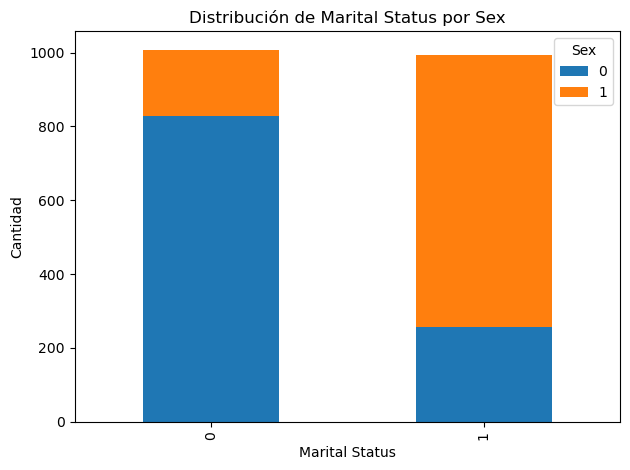

In [19]:

# Graficar barras apiladas
tabla_ka_cont.plot(kind='bar', stacked=True)
plt.xlabel('Marital Status')
plt.ylabel('Cantidad')
plt.title('Distribución de Marital Status por Sex')
plt.legend(title='Sex')
plt.tight_layout()
plt.show()

In [20]:
phi = phi = matthews_corrcoef(df_ka["marital_bin"].cat.codes, df_ka["sex_bin"].cat.codes)
print(f"Coeficiente phi: {phi:.4f}")

Coeficiente phi: 0.5665


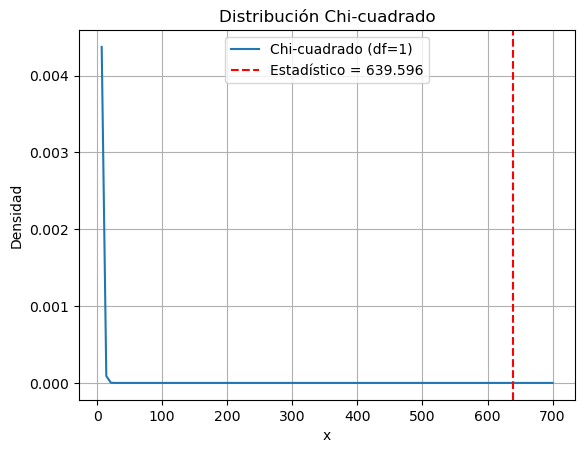

In [21]:
# Rango de valores en el eje x
x = np.linspace(0, 700, 100)

# Calcular la densidad
pdf = chi2.pdf(x, dof_corr)

# Graficar
plt.plot(x, pdf, label=f'Chi-cuadrado (df={dof_corr})')
plt.axvline(x=chi2_corr, color='red', linestyle='--', label=f'Estadístico = {chi2_corr:.3f}')
plt.title('Distribución Chi-cuadrado')
plt.xlabel('x')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True)
plt.show()
